In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [3]:
!cp /content/drive/MyDrive/The\ School\ of\ AI/ERAV3/ERAv3_Session7_Assignment_v1/model_v2.py /content
!cp /content/drive/MyDrive/The\ School\ of\ AI/ERAV3/ERAv3_Session7_Assignment_v1/utils_v2.py /content

In [4]:
import model_v2
import utils_v2
from model_v2 import Net
from utils_v2 import *

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
CUDA Available? True
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
CUDA Available? True


In [5]:
# Train data transformations
train_transforms = transforms.Compose([
    #transforms.RandomApply([transforms.CenterCrop(22), ], p=0.1),
    transforms.Resize((28, 28)),
    transforms.RandomRotation((-7.0, 7.0), fill=(1,)), # do it in later attempt
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)),
    ])

# Test data transformations
test_transforms = transforms.Compose([
    transforms.ToTensor(),
    #transforms.Normalize((0.1407,), (0.4081,)) --> This is incorrect line and hence commented
    transforms.Normalize((0.1307,), (0.3081,))
    ])

In [6]:
train_data = datasets.MNIST('../data', train=True, download=True, transform=train_transforms)
#test_data = datasets.MNIST('../data', train=True, download=True, transform=train_transforms) --> Commented the incorrect line. train = False and test_transform needs to be passed
test_data = datasets.MNIST('../data', train=False, download=True, transform=test_transforms)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:00<00:00, 17.9MB/s]


Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 487kB/s]


Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:00<00:00, 4.46MB/s]


Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 3.92MB/s]

Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw



In [7]:
type(train_data), len(train_data), len(train_data[0]), train_data.data.shape, test_data.data.shape

(torchvision.datasets.mnist.MNIST,
 60000,
 2,
 torch.Size([60000, 28, 28]),
 torch.Size([10000, 28, 28]))

In [8]:
SEED = 1
# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

batch_size = 128

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

#kwargs = {'batch_size': batch_size, 'shuffle': False, 'num_workers': 2, 'pin_memory': True} --> Commented the incorrect line. shuffle parameter needs to be True
kwargs = {'batch_size': batch_size, 'shuffle': True, 'num_workers': 2, 'pin_memory': True}

#test_loader = torch.utils.data.DataLoader(train_data, **kwargs) --> Commented the incorrect line. test_data needs be passed for test_loader
test_loader = torch.utils.data.DataLoader(test_data, **kwargs)
train_loader = torch.utils.data.DataLoader(train_data, **kwargs)

CUDA Available? True


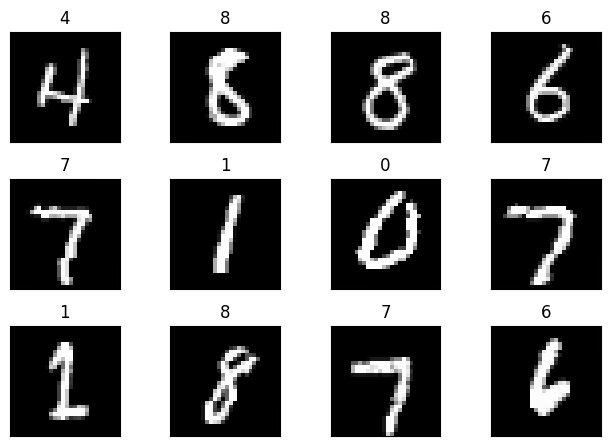

In [9]:
import matplotlib.pyplot as plt

batch_data, batch_label = next(iter(train_loader))

fig = plt.figure()

for i in range(12):
  plt.subplot(3,4,i+1)
  plt.tight_layout()
  plt.imshow(batch_data[i].squeeze(0), cmap='gray')
  plt.title(batch_label[i].item())
  plt.xticks([])
  plt.yticks([])

In [10]:
from tqdm import tqdm

In [ ]:
# Data to plot accuracy and loss graphs
#train_losses = []
#test_losses = []
#train_acc = []
#test_acc = []

#test_incorrect_pred = {'images': [], 'ground_truths': [], 'predicted_vals': []}

In [11]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [12]:
!pip install torchsummary
from torchsummary import summary

In [13]:
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
              ReLU-2            [-1, 8, 26, 26]               0
       BatchNorm2d-3            [-1, 8, 26, 26]              16
           Dropout-4            [-1, 8, 26, 26]               0
            Conv2d-5           [-1, 16, 24, 24]           1,152
              ReLU-6           [-1, 16, 24, 24]               0
       BatchNorm2d-7           [-1, 16, 24, 24]              32
           Dropout-8           [-1, 16, 24, 24]               0
            Conv2d-9           [-1, 16, 22, 22]           2,304
             ReLU-10           [-1, 16, 22, 22]               0
      BatchNorm2d-11           [-1, 16, 22, 22]              32
          Dropout-12           [-1, 16, 22, 22]               0
           Conv2d-13           [-1, 32, 20, 20]           4,608
             ReLU-14           [-1, 32,

In [14]:
import torch.optim.lr_scheduler as lrs

In [15]:
model = Net().to(device)
#optimizer = optim.SGD(model.parameters(), lr=10.01, momentum=0.9) -- Commented the line since learning rate needs to be corrected
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
#scheduler = lrs.ReduceLROnPlateau(optimizer, 'min',patience = 3, verbose=True)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=6, gamma=0.1, verbose=True)
# New Line
criterion = nn.CrossEntropyLoss()
#criterion = F.nll_loss()
num_epochs = 20

for epoch in range(1, num_epochs+1):
  print(f'Epoch {epoch}')
  train(model, device, train_loader, optimizer, criterion)
  #test(model, device, train_loader) --> Removed this incorrect line. test_loader needs to be passed here
  test(model, device, test_loader, criterion)
  scheduler.step()

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1


Train: Loss=0.1002 Batch_id=468 Accuracy=90.32: 100%|██████████| 469/469 [00:22<00:00, 20.93it/s]


Test set: Average loss: 0.0527, Accuracy: 9859/10000 (98.59%)

Epoch 2


Train: Loss=0.0378 Batch_id=468 Accuracy=97.89: 100%|██████████| 469/469 [00:25<00:00, 18.63it/s]


Test set: Average loss: 0.0344, Accuracy: 9906/10000 (99.06%)

Epoch 3


Train: Loss=0.0584 Batch_id=468 Accuracy=98.38: 100%|██████████| 469/469 [00:23<00:00, 19.71it/s]


Test set: Average loss: 0.0339, Accuracy: 9906/10000 (99.06%)

Epoch 4


Train: Loss=0.0349 Batch_id=468 Accuracy=98.49: 100%|██████████| 469/469 [00:23<00:00, 20.16it/s]


Test set: Average loss: 0.0243, Accuracy: 9927/10000 (99.27%)

Epoch 5


Train: Loss=0.0539 Batch_id=468 Accuracy=98.60: 100%|██████████| 469/469 [00:26<00:00, 17.47it/s]


Test set: Average loss: 0.0269, Accuracy: 9913/10000 (99.13%)

Epoch 6


Train: Loss=0.0191 Batch_id=468 Accuracy=98.75: 100%|██████████| 469/469 [00:22<00:00, 20.78it/s]


Test set: Average loss: 0.0234, Accuracy: 9932/10000 (99.32%)

Epoch 7


Train: Loss=0.0450 Batch_id=468 Accuracy=99.00: 100%|██████████| 469/469 [00:23<00:00, 20.21it/s]


Test set: Average loss: 0.0190, Accuracy: 9947/10000 (99.47%)

Epoch 8


Train: Loss=0.0960 Batch_id=468 Accuracy=99.03: 100%|██████████| 469/469 [00:24<00:00, 18.95it/s]


Test set: Average loss: 0.0188, Accuracy: 9945/10000 (99.45%)

Epoch 9


Train: Loss=0.0427 Batch_id=468 Accuracy=99.11: 100%|██████████| 469/469 [00:23<00:00, 19.60it/s]


Test set: Average loss: 0.0175, Accuracy: 9945/10000 (99.45%)

Epoch 10


Train: Loss=0.0127 Batch_id=468 Accuracy=99.08: 100%|██████████| 469/469 [00:22<00:00, 20.89it/s]


Test set: Average loss: 0.0180, Accuracy: 9944/10000 (99.44%)

Epoch 11


Train: Loss=0.0242 Batch_id=468 Accuracy=99.14: 100%|██████████| 469/469 [00:23<00:00, 19.92it/s]


Test set: Average loss: 0.0182, Accuracy: 9944/10000 (99.44%)

Epoch 12


Train: Loss=0.0201 Batch_id=468 Accuracy=99.10: 100%|██████████| 469/469 [00:24<00:00, 19.49it/s]


Test set: Average loss: 0.0177, Accuracy: 9946/10000 (99.46%)

Epoch 13


Train: Loss=0.0355 Batch_id=468 Accuracy=99.16: 100%|██████████| 469/469 [00:23<00:00, 20.22it/s]


Test set: Average loss: 0.0172, Accuracy: 9945/10000 (99.45%)

Epoch 14


Train: Loss=0.0308 Batch_id=468 Accuracy=99.19: 100%|██████████| 469/469 [00:22<00:00, 21.15it/s]


Test set: Average loss: 0.0173, Accuracy: 9947/10000 (99.47%)

Epoch 15


Train: Loss=0.0078 Batch_id=468 Accuracy=99.17: 100%|██████████| 469/469 [00:24<00:00, 19.48it/s]


Test set: Average loss: 0.0175, Accuracy: 9946/10000 (99.46%)

Epoch 16


Train: Loss=0.0241 Batch_id=468 Accuracy=99.11: 100%|██████████| 469/469 [00:23<00:00, 19.57it/s]


Test set: Average loss: 0.0176, Accuracy: 9945/10000 (99.45%)

Epoch 17


Train: Loss=0.0073 Batch_id=468 Accuracy=99.13: 100%|██████████| 469/469 [00:22<00:00, 21.20it/s]


Test set: Average loss: 0.0172, Accuracy: 9947/10000 (99.47%)

Epoch 18


Train: Loss=0.0270 Batch_id=468 Accuracy=99.14: 100%|██████████| 469/469 [00:22<00:00, 20.72it/s]


Test set: Average loss: 0.0172, Accuracy: 9945/10000 (99.45%)

Epoch 19


Train: Loss=0.0532 Batch_id=468 Accuracy=99.19: 100%|██████████| 469/469 [00:23<00:00, 19.81it/s]


Test set: Average loss: 0.0172, Accuracy: 9946/10000 (99.46%)

Epoch 20


Train: Loss=0.0492 Batch_id=468 Accuracy=99.16: 100%|██████████| 469/469 [00:22<00:00, 20.52it/s]


Test set: Average loss: 0.0176, Accuracy: 9944/10000 (99.44%)



In [16]:
import matplotlib.pyplot as plt

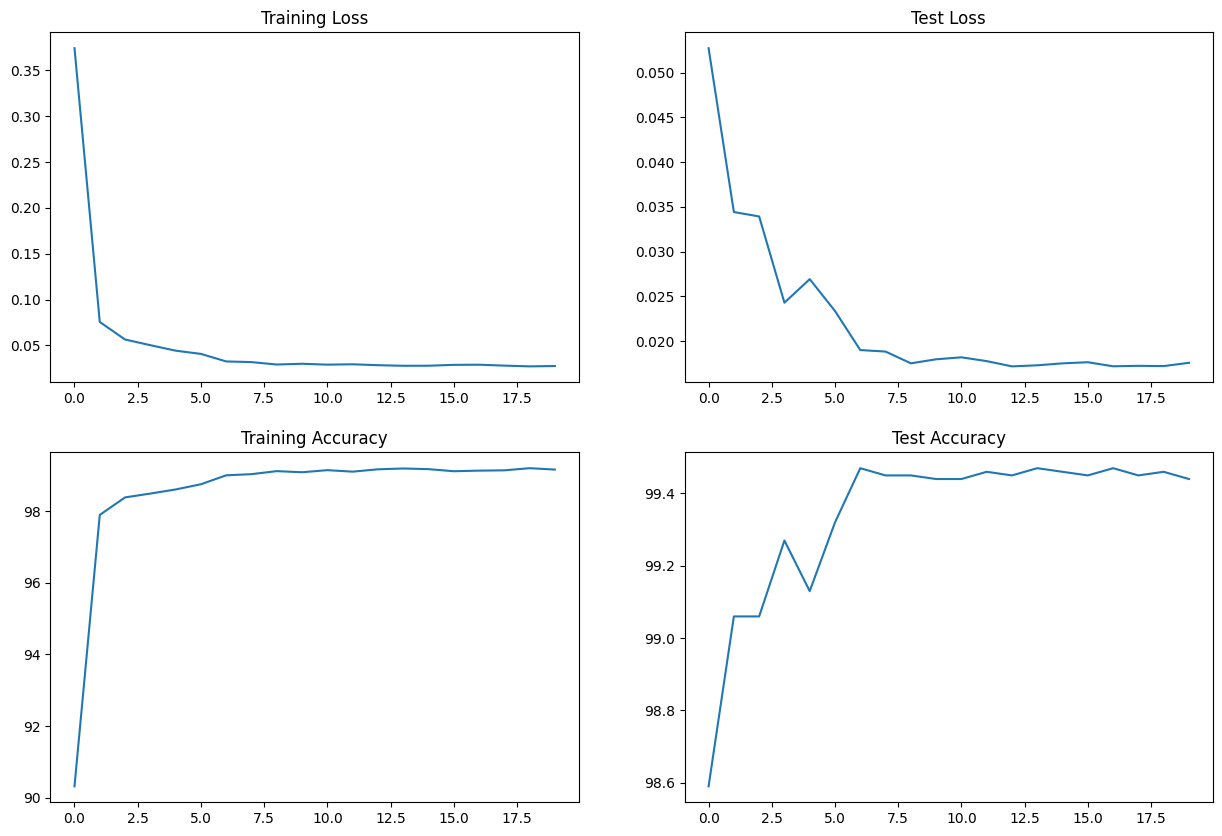

In [17]:
# plotting to be fixed in next attempt
printTrainTest_LossAcc(train_losses,train_acc,test_losses,test_acc)

1. Model has been made lighter with 17k parameters.
2. Implemented image augmentation - rotation to gain further accuracy
2. Train and test accurayc gap is less.
3. Best Train accuracy : 99.19%
2. Test acuracy : 99.46%. Max. test accuracy of 99.36% reached in 17th Epoch
3. model maintains consistency across epoch between train and test accuracies.
4. we can add more image augmentation in this model now to push accuracy further
5.
   
  